In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd


In [ ]:
def CleanRawData(file_path):

  # Loading data as String
  with  open(file_path) as f: 
    txt_train = f.read()
    f.close()

  # Delete'ip','timestamp','raw_messages','status_scores'from the Raw Data.
  txt_train = txt_train.replace('ip:','')
  txt_train = txt_train.replace('timestamp:','')
  txt_train = txt_train.replace('raw_messages:','')
  txt_train = txt_train.replace('status_score:','')

  # Write the modified string to a txt file
  with open(file_path,'w') as f:    
    f.write(txt_train)

  # Read the txt file into the csv required by machine learning to facilitate our subsequent processing.
  df = pd.read_csv(file_path,
                         delimiter=",",header= None,
                         names=('ip','timestamp','raw_messages','status_score'))
  
  return df

In [ ]:
df =CleanRawData('/content/drive/My Drive/exercise/train.txt')
df_lstm = df.loc[:,['timestamp','status_score']]
def fillVaules(object):
  object['status_score'] = object['status_score'].interpolate(method = 'linear')
fillVaules(df_lstm)
df_lstm['timestamp'] = pd.to_datetime(df_lstm['timestamp'],unit='s')

In [ ]:
#设置时间戳索引
df_lstm['timestamp'] = pd.to_datetime(df_lstm['timestamp'])
df_lstm.set_index("timestamp", inplace=True)

df_lstm

###Split Data

In [ ]:
from numpy import split
from numpy import array
from pandas import read_csv
 

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks

	train, test = df_lstm[0:500], df_lstm[500:]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/50))
	test = array(split(test, len(test)/50))
	return train, test
 
# load the new file

train, test = split_dataset(df_lstm.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(10, 50, 1)
1.0006245939086245 -0.2258127201836195
(1, 50, 1)
-1.0345353748427155 -1.7250154050852642


### Evaluation

In [ ]:

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))


In [ ]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

### to supervised data

接受一个50个points列表(历史记录)和作为输入和输出使用的时间步数，并以重叠的移动窗口格式返回数据。

In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [ ]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [ ]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

### Together

In [ ]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
 
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into 10*5 train data size ,

	train, test = df_lstm[0:500], df_lstm[500:]
	# restructure into windows of 50 periodic data
	train = array(split(train, len(train)/50))
	test = array(split(test, len(test)/50))
	return train, test
 
# load the new file

train, test = split_dataset(df_lstm.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])
 
# evaluate one or more periodict forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=50):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 
# train the model
def build_model(train,n_input):
  # prepare data
  train_x,train_y = to_supervised(train,n_input)
  #define parameters
  verbose, epochs, batch_size = 0,70,16
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  #define model 
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape = (n_timesteps,n_features)))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs))
  model.compile(loss = 'mse',optimizer='adam')
  #fit model
  model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,verbose = verbose)
  model.save('/content/drive/My Drive/exercise/LSTM')
  return model
 


# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next 50
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the 50
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores
 
# load the new file
dataset = df_lstm
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 50
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm',score, scores)
#Save model 
# plot scores

(10, 50, 1)
1.0006245939086245 -0.2258127201836195
(1, 50, 1)
-1.0345353748427155 -1.7250154050852642
INFO:tensorflow:Assets written to: /content/drive/My Drive/exercise/LSTM/assets
lstm: [4.138] 0.0, 2.7, 0.7, 25.8, 1.8, 1.1, 0.5, 0.1, 0.4, 0.2, 0.7, 0.7, 0.5, 0.9, 4.9, 5.9, 1.4, 1.0, 1.3, 0.2, 0.7, 0.3, 0.3, 0.2, 0.9, 2.2, 5.8, 3.0, 0.2, 1.8, 1.0, 0.6, 0.7, 0.6, 0.9, 0.2, 2.5, 3.8, 5.0, 2.5, 1.0, 0.8, 1.2, 0.4, 0.2, 0.1, 0.2, 0.6, 0.4, 0.8


In [ ]:
from tensorflow import keras
LSTM_model = keras.models.load_model('/content/drive/My Drive/exercise/LSTM')

In [ ]:
pred_y = LSTM_model.predict(test)

In [ ]:
# convert (1,50) to (50,1)
pred_y = pred_y.reshape(50,1)

In [ ]:
pred_y

In [ ]:
# Define function of Clean Test.txt
def CleanTestData(file_path):
    with open(file_path) as f:
      txt_test = f.read()
      f.close()

    # Do the same data processing on the test.txt.
    txt_test = txt_test.replace('timestamp:','')

    with open(file_path,'w') as f:    
      f.write(txt_test)
    
    df_pred = pd.read_csv(file_path,
                          delimiter=",",header= None)
    
    df_pred.columns = ['timestamp']
    return df_pred

def convert_test_index_timestmp():
  # Do the same data processing on the test.txt.
  df_pred['timestamp'] = pd.to_datetime(df_pred['timestamp'])
  df_pred.set_index("timestamp", inplace=True)

In [ ]:
df_pred = CleanTestData('/content/drive/My Drive/exercise/test.txt')

df_pred['timestamp'] = pd.to_datetime(df_pred['timestamp'],unit='s')

In [ ]:
df_pred = df_pred.values

In [ ]:
# convert (1,50) to (50,1)
df_pred = df_pred.reshape(50,1)

In [ ]:
#Convert a two-dimensional array to one-dimensional.
df_pred = df_pred.ravel()

In [ ]:
# Convert a two-dimensional array to one-dimensional.
pred_y =pred_y.ravel()

In [ ]:
pred_all= pd.DataFrame(columns={'timestamp','Test_Prediction'})
pred_all['timestamp'] = df_pred
pred_all['Test_Prediction'] = pred_y

In [ ]:
pred_all['timestamp'] = pd.to_datetime(pred_all['timestamp'])
pred_all.set_index("timestamp", inplace=True)

In [ ]:
df_all = pd.concat([df_lstm,pred_all])  

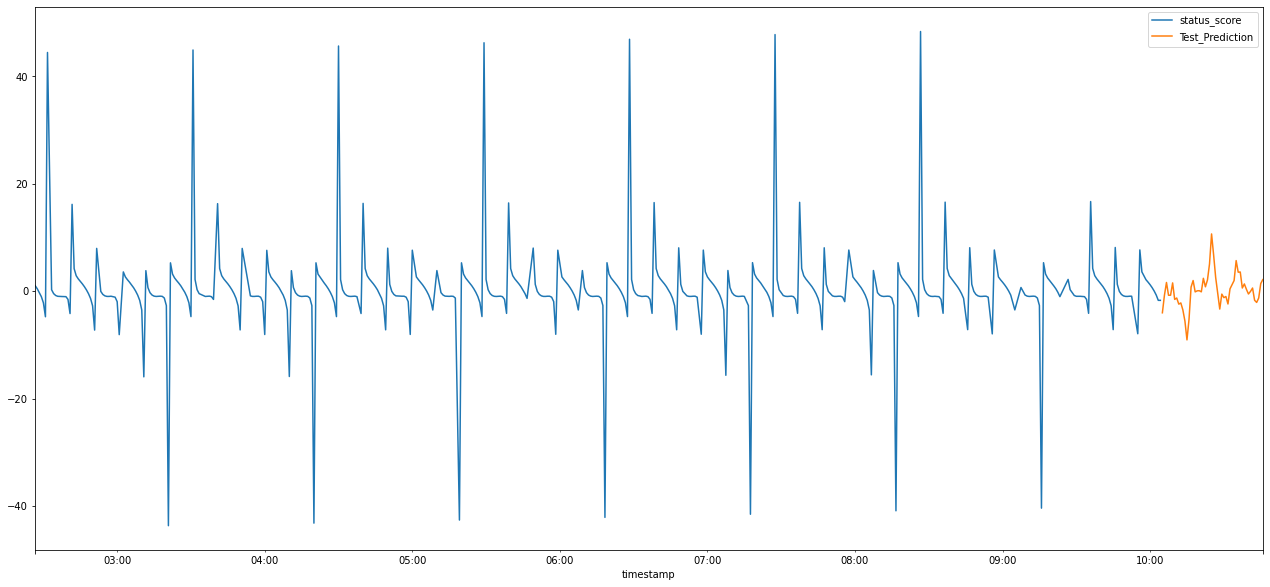

In [ ]:
check_lstm= df_all[['status_score','Test_Prediction']].plot(figsize=(22, 10))